In [12]:
pip install yfinance nltk scikit-learn vaderSentiment tensorflow

In [13]:
import requests
import openpyxl
import numpy as np
from bs4 import BeautifulSoup
import time
import pandas as pd
from textblob import TextBlob
import re
import spacy
import yfinance as yf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [81]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Stemming
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a single string
    return ' '.join(words)

In [15]:
def extract_features(headlines):
    # Vectorize text
    vectorizer = CountVectorizer(max_features=2000)
    X = vectorizer.fit_transform(headlines)

    # Topic modeling
    lda = LatentDirichletAllocation(n_components=7, random_state=0)
    lda_features = lda.fit_transform(X)

    # Sentiment analysis
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = [analyzer.polarity_scores(headline) for headline in headlines]

    sentiment_df = pd.DataFrame(sentiment_scores)
    sentiment_df = sentiment_df[['compound', 'neg', 'neu', 'pos']]

    return pd.concat([pd.DataFrame(lda_features), sentiment_df], axis=1)

Web Scrapping for Amazon

In [16]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import yfinance as yf

def fetch_headlines_and_dates(page_number):
    url = f"https://markets.businessinsider.com/news/amzn-stock?p={page_number}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    for attempt in range(3):  # Try 3 times before giving up
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                headlines_and_dates = []
                news_items = soup.find_all('div', class_='latest-news__story')  # Adjust based on the actual structure of the news items
                for item in news_items:
                    headline_tag = item.find('a', class_='news-link')
                    if headline_tag:
                        headline = headline_tag.get_text(strip=True)
                        date_tag = item.find('time', class_='latest-news__date')
                        if date_tag and date_tag.has_attr('datetime'):
                            full_datetime = date_tag['datetime']
                            date = full_datetime.split(' ')[0]  # Extract the date part only
                            headlines_and_dates.append((date, headline))
                return headlines_and_dates
            else:
                print(f"Failed to fetch page {page_number}, status code: {response.status_code}")
        except requests.RequestException as e:
            print(f"Error fetching page {page_number}: {e}")
        time.sleep(5)  # Wait 5 seconds before retrying
    return []

def calculate_moving_averages(prices, window):
    return prices.rolling(window=window).mean()

In [17]:
    all_headlines_and_dates = []
    for page in range(1, 201):  # Loop through 201 pages for training the data and remaining for testing the data later
        print(f"Fetching page {page}")
        headlines_and_dates = fetch_headlines_and_dates(page)
        if headlines_and_dates:
            all_headlines_and_dates.extend(headlines_and_dates)
        else:
            print(f"No data fetched for page {page}, stopping.")
            break
        time.sleep(1)  # Wait 1 second between requests

Fetching page 1
Fetching page 2
Fetching page 3
Fetching page 4
Fetching page 5
Fetching page 6
Fetching page 7
Fetching page 8
Fetching page 9
Fetching page 10
Fetching page 11
Fetching page 12
Fetching page 13
Fetching page 14
Fetching page 15
Fetching page 16
Fetching page 17
Fetching page 18
Fetching page 19
Fetching page 20
Fetching page 21
Fetching page 22
Fetching page 23
Fetching page 24
Fetching page 25
Fetching page 26
Fetching page 27
Fetching page 28
Fetching page 29
Fetching page 30
Fetching page 31
Fetching page 32
Fetching page 33
Fetching page 34
Fetching page 35
Fetching page 36
Fetching page 37
Fetching page 38
Fetching page 39
Fetching page 40
Fetching page 41
Fetching page 42
Fetching page 43
Fetching page 44
Fetching page 45
Fetching page 46
Fetching page 47
Fetching page 48
Fetching page 49
Fetching page 50
Fetching page 51
Fetching page 52
Fetching page 53
Fetching page 54
Fetching page 55
Fetching page 56
Fetching page 57
Fetching page 58
Fetching page 59
Fetchi

In [47]:
import pandas as pd
import yfinance as yf

# Convert to DataFrame
df = pd.DataFrame(all_headlines_and_dates, columns=["Date", "Headline"])
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure proper order
df.sort_values('Date', inplace=True)

# Preprocess headlines
df['Cleaned_Headline'] = df['Headline'].apply(preprocess_text)

# Fetch stock data using yfinance
stock_data = yf.download('AMZN', start=df['Date'].min(), end=df['Date'].max() + pd.Timedelta(days=1))
stock_data.reset_index(inplace=True)

# Calculate moving averages and volatility
stock_data['7_day_MA'] = calculate_moving_averages(stock_data['Close'], 7)
stock_data['30_day_MA'] = calculate_moving_averages(stock_data['Close'], 30)
stock_data['Volatility'] = stock_data['Close'].rolling(window=7).std()

# Create a dictionary to hold headlines for each date
date_to_headlines = df.groupby('Date')['Cleaned_Headline'].apply('.'.join).to_dict()

# Initialize a list to hold merged headlines
merged_headlines = []

# Track the last trading date
last_trading_date = None

# Iterate through the date range
for current_date in pd.date_range(start=df['Date'].min(), end=df['Date'].max()):
    if current_date in stock_data['Date'].values:
        # If current date is a trading day, record it and append its headlines
        last_trading_date = current_date
        headline = date_to_headlines.get(current_date, '')
        merged_headlines.append({'Date': current_date, 'Headline': headline})
    else:
        # If current date is not a trading day, append its headlines to the last trading day
        if last_trading_date is not None:
            # Find the last trading day entry in merged_headlines and update its headline
            for entry in merged_headlines:
                if entry['Date'] == last_trading_date:
                    entry['Headline'] += '.' + date_to_headlines.get(current_date, '')

# Create a DataFrame for merged headlines
merged_df = pd.DataFrame(merged_headlines)

# Extract features from merged headlines
features_df = extract_features(merged_df['Headline'])

# Merge headlines with stock data
merged_df = pd.merge(merged_df, stock_data, left_on='Date', right_on='Date')

# Merge the extracted features
merged_df = pd.concat([merged_df, features_df], axis=1)

# Remove rows where markets are closed (if any)
merged_df = merged_df.dropna(subset=['Close'])

# Add label column
merged_df['Label'] = (merged_df['Close'].shift(-1) > merged_df['Close']).astype(int)


# Reset index
merged_df.reset_index(drop=True, inplace=True)

# Output the final merged DataFrame
merged_df


[*********************100%%**********************]  1 of 1 completed


,Date,Headline,Open,High,Low,Close,Adj Close,Volume,7_day_MA,30_day_MA,...,2,3,4,5,6,compound,neg,neu,pos,Label
0,2019-05-02,microsoft unveil new azur servic develop quick...,95.666496,96.077499,94.093498,95.041000,95.041000,79258000,NaN,NaN,...,0.015915,0.015913,0.015926,0.015883,0.904573,0.0000,0.000,1.000,0.000,1
1,2019-05-03,microsoft partner jpmorgan chase blockchain pr...,97.449997,98.220001,96.800003,98.123001,98.123001,127632000,NaN,NaN,...,0.017896,0.258671,0.651899,0.017860,0.017911,0.0000,0.000,1.000,0.000,0
2,2019-05-06,microsoft tea futurist new way play minecraft ...,95.899002,97.949997,95.525002,97.527496,97.527496,108356000,NaN,NaN,...,0.011943,0.011946,0.011948,0.011947,0.928364,0.5859,0.111,0.602,0.287,0
3,2019-05-07,,96.999496,97.455002,95.168999,96.050003,96.050003,118042000,NaN,NaN,...,0.142857,0.142857,0.142857,0.142857,0.142857,0.0000,0.000,0.000,0.000,0
4,2019-05-08,photo googl microsoft ceo show far taken rival...,95.943497,96.768501,95.500000,95.888496,95.888496,81572000,NaN,NaN,...,0.015934,0.015908,0.015923,0.015900,0.904518,0.0000,0.000,1.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,2024-06-12,appl overtak microsoft return world valuabl co...,188.020004,188.350006,185.429993,186.889999,186.889999,33984200,184.442856,184.044000,...,0.743163,0.000595,0.000595,0.000596,0.000595,0.9920,0.006,0.821,0.173,0
1288,2024-06-13,3 ai stock worthi challeng nvidia.tech ai driv...,186.089996,187.669998,182.669998,183.830002,183.830002,39721500,185.084285,184.205000,...,0.992710,0.001216,0.001215,0.001216,0.001214,0.9661,0.027,0.796,0.177,0
1289,2024-06-14,microsoft delay releas recal featur secur conc...,183.080002,183.720001,182.229996,183.660004,183.660004,25456400,185.424286,184.169667,...,0.784035,0.018601,0.001293,0.001293,0.001292,0.9337,0.048,0.799,0.152,1
1290,2024-06-17,tyler technolog ride grow custom base.microsof...,182.520004,185.000000,181.220001,184.059998,184.059998,35601900,185.290000,184.098000,...,0.988057,0.001989,0.001994,0.001989,0.001991,0.0000,0.000,1.000,0.000,0


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [20]:
# Filter out rows with headlines containing at least one alphabetic character or at least one numeric character
filtered_df = merged_df[merged_df['Headline'].str.contains('[a-zA-Z]|\d', regex=True)]

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

# Define features and target
X = filtered_df.drop(columns=[ 'Label','Date', 'Headline'])
y = filtered_df['Label']

# Handle any remaining NaN values
X = X.fillna(X.mean())

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Accuracy: 0.543010752688172
Precision: 0.54
Recall: 0.5806451612903226
F1-Score: 0.5595854922279794
[[47 46]
 [39 54]]
              precision    recall  f1-score   support

           0       0.55      0.51      0.53        93
           1       0.54      0.58      0.56        93

    accuracy                           0.54       186
   macro avg       0.54      0.54      0.54       186
weighted avg       0.54      0.54      0.54       186



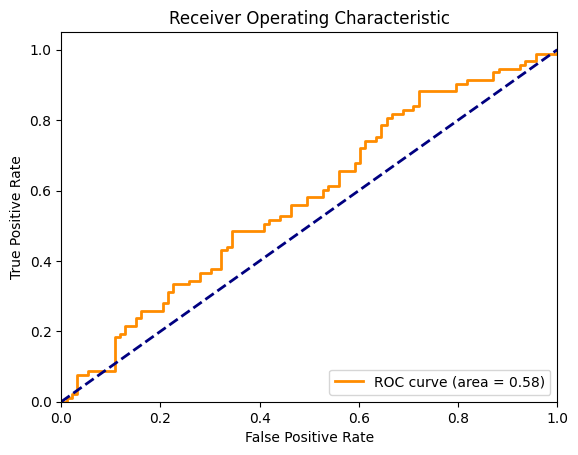

In [22]:
    # Train the logistic regression model
    model1 = LogisticRegression()
    model1.fit(X_train, y_train)

    # Make predictions
    y_pred1 = model1.predict(X_test)
    y_pred_prob1 = model1.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred1)}")
    print(f"Precision: {precision_score(y_test, y_pred1)}")
    print(f"Recall: {recall_score(y_test, y_pred1)}")
    print(f"F1-Score: {f1_score(y_test, y_pred1)}")
    print(confusion_matrix(y_test, y_pred1))
    print(classification_report(y_test, y_pred1))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


Accuracy: 0.4838709677419355
Precision: 0.4838709677419355
Recall: 0.4838709677419355
F1-Score: 0.4838709677419355
[[45 48]
 [48 45]]
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        93
           1       0.48      0.48      0.48        93

    accuracy                           0.48       186
   macro avg       0.48      0.48      0.48       186
weighted avg       0.48      0.48      0.48       186



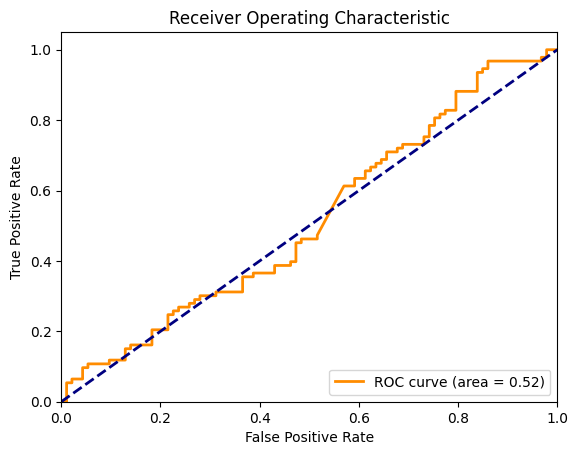

In [23]:
    # Train the SVM model
    model2 = SVC(probability=True)
    model2.fit(X_train, y_train)

    # Make predictions
    y_pred2 = model2.predict(X_test)
    y_pred_prob2 = model2.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred2)}")
    print(f"Precision: {precision_score(y_test, y_pred2)}")
    print(f"Recall: {recall_score(y_test, y_pred2)}")
    print(f"F1-Score: {f1_score(y_test, y_pred2)}")
    print(confusion_matrix(y_test, y_pred2))
    print(classification_report(y_test, y_pred2))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob2)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.5053763440860215
Precision: 0.5057471264367817
Recall: 0.4731182795698925
F1-Score: 0.4888888888888889
[[50 43]
 [49 44]]
              precision    recall  f1-score   support

           0       0.51      0.54      0.52        93
           1       0.51      0.47      0.49        93

    accuracy                           0.51       186
   macro avg       0.51      0.51      0.50       186
weighted avg       0.51      0.51      0.50       186



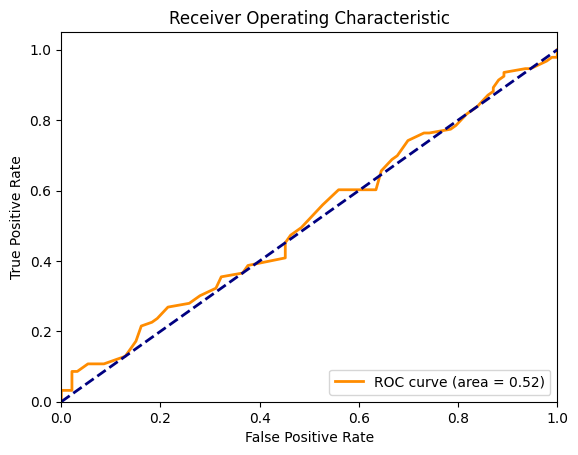

In [24]:
    model3 = RandomForestClassifier(n_estimators=100, random_state=42)
    model3.fit(X_train, y_train)

    # Make predictions
    y_pred3 = model3.predict(X_test)
    y_pred_prob3 = model3.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred3)}")
    print(f"Precision: {precision_score(y_test, y_pred3)}")
    print(f"Recall: {recall_score(y_test, y_pred3)}")
    print(f"F1-Score: {f1_score(y_test, y_pred3)}")
    print(confusion_matrix(y_test, y_pred3))
    print(classification_report(y_test, y_pred3))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob3)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.5172413793103449
Precision: 0.5
Recall: 0.5357142857142857
F1-Score: 0.5172413793103449
[[30 30]
 [26 30]]
              precision    recall  f1-score   support

           0       0.54      0.50      0.52        60
           1       0.50      0.54      0.52        56

    accuracy                           0.52       116
   macro avg       0.52      0.52      0.52       116
weighted avg       0.52      0.52      0.52       116



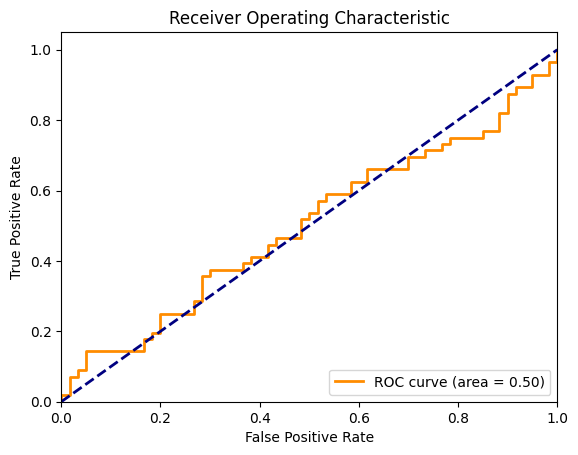

In [116]:
    from sklearn.neural_network import MLPClassifier

# Initialize and train Neural Network model
    model4 = MLPClassifier(max_iter=2000)
    model4.fit(X_train, y_train)


    # Make predictions
    y_pred4 = model4.predict(X_test)
    y_pred_prob4 = model4.predict_proba(X_test)[:, 1]


    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred4)}")
    print(f"Precision: {precision_score(y_test, y_pred4)}")
    print(f"Recall: {recall_score(y_test, y_pred4)}")
    print(f"F1-Score: {f1_score(y_test, y_pred4)}")
    print(confusion_matrix(y_test, y_pred4))
    print(classification_report(y_test, y_pred4))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob4)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Finding the best model

In [48]:
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)
accuracy3 = accuracy_score(y_test, y_pred3)
accuracy4 = accuracy_score(y_test, y_pred4)
accuracies = {
    'Logistic Regression': accuracy1,
    'SVM': accuracy2,
    'Random Forest': accuracy3,
    'Neural Network': accuracy4
}

best_model_name = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model_name]

print(f"Best model: {best_model_name} with accuracy: {best_accuracy}")

# Optional: Store the best model for future use
if best_model_name == 'Logistic Regression':
    best_model = model1
elif best_model_name == 'SVM':
    best_model = model2
elif best_model_name == 'Random Forest':
    best_model = model3
else:
    best_model = model4

Best model: Neural Network with accuracy: 0.53515625


In [27]:
    headlines_test = []
    for page in range(201, 401):  # Loop through remaining pages for using it in further strategy(i.e backtesting)
        print(f"Fetching page {page}")
        headlines_and_dates = fetch_headlines_and_dates(page)
        if headlines_and_dates:
            headlines_test.extend(headlines_and_dates)
        else:
            print(f"No data fetched for page {page}, stopping.")
            break
        time.sleep(1)  # Wait 1 second between requests

Fetching page 201
Fetching page 202
Fetching page 203
Fetching page 204
Fetching page 205
Fetching page 206
Fetching page 207
Fetching page 208
Fetching page 209
Fetching page 210
Fetching page 211
Fetching page 212
Fetching page 213
Fetching page 214
Fetching page 215
Fetching page 216
Fetching page 217
Fetching page 218
Fetching page 219
Fetching page 220
Fetching page 221
Fetching page 222
Fetching page 223
Fetching page 224
Fetching page 225
Fetching page 226
Fetching page 227
Fetching page 228
Fetching page 229
Fetching page 230
Fetching page 231
Fetching page 232
Fetching page 233
Fetching page 234
Fetching page 235
Fetching page 236
Fetching page 237
Fetching page 238
Fetching page 239
Fetching page 240
Fetching page 241
Fetching page 242
Fetching page 243
Fetching page 244
Fetching page 245
Fetching page 246
Fetching page 247
Fetching page 248
Fetching page 249
Fetching page 250
Fetching page 251
Fetching page 252
Fetching page 253
Fetching page 254
Fetching page 255
Fetching p

In [28]:
import pandas as pd
import yfinance as yf

# Convert to DataFrame
df = pd.DataFrame(headlines_test, columns=["Date", "Headline"])
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure proper order
df.sort_values('Date', inplace=True)

# Preprocess headlines
df['Cleaned_Headline'] = df['Headline'].apply(preprocess_text)

# Fetch stock data using yfinance
stock_data = yf.download('AMZN', start=df['Date'].min(), end=df['Date'].max() + pd.Timedelta(days=1))
stock_data.reset_index(inplace=True)

# Calculate moving averages and volatility
stock_data['7_day_MA'] = calculate_moving_averages(stock_data['Close'], 7)
stock_data['30_day_MA'] = calculate_moving_averages(stock_data['Close'], 30)
stock_data['Volatility'] = stock_data['Close'].rolling(window=7).std()

# Create a dictionary to hold headlines for each date
date_to_headlines = df.groupby('Date')['Cleaned_Headline'].apply('.'.join).to_dict()

# Initialize a list to hold merged headlines
merged_headlines = []

# Track the last trading date
last_trading_date = None

# Iterate through the date range
for current_date in pd.date_range(start=df['Date'].min(), end=df['Date'].max()):
    if current_date in stock_data['Date'].values:
        # If current date is a trading day, record it and append its headlines
        last_trading_date = current_date
        headline = date_to_headlines.get(current_date, '')
        merged_headlines.append({'Date': current_date, 'Headline': headline})
    else:
        # If current date is not a trading day, append its headlines to the last trading day
        if last_trading_date is not None:
            # Find the last trading day entry in merged_headlines and update its headline
            for entry in merged_headlines:
                if entry['Date'] == last_trading_date:
                    entry['Headline'] += '.' + date_to_headlines.get(current_date, '')

# Create a DataFrame for merged headlines
merged_df2 = pd.DataFrame(merged_headlines)

# Extract features from merged headlines
features_df = extract_features(merged_df2['Headline'])

# Merge headlines with stock data
merged_df2 = pd.merge(merged_df2, stock_data, left_on='Date', right_on='Date')

# Merge the extracted features
merged_df2 = pd.concat([merged_df2, features_df], axis=1)

# Remove rows where markets are closed (if any)
merged_df2 = merged_df2.dropna(subset=['Close'])


# Reset index
merged_df2.reset_index(drop=True, inplace=True)

# Output the final merged DataFrame
merged_df2


[*********************100%%**********************]  1 of 1 completed


,Date,Headline,Open,High,Low,Close,Adj Close,Volume,7_day_MA,30_day_MA,...,1,2,3,4,5,6,compound,neg,neu,pos
0,2017-05-04,p 500 tech index edg toward 5 trillion appl st...,47.237499,47.250000,46.710999,46.876499,46.876499,48368000,NaN,NaN,...,0.001773,0.133705,0.001768,0.001769,0.857446,0.001771,0.8074,0.031,0.836,0.133
1,2017-05-05,wall st weekahead old guard retail back cross ...,47.026001,47.039501,46.514999,46.707500,46.707500,57328000,NaN,NaN,...,0.001147,0.001148,0.001147,0.001148,0.503742,0.198837,0.8720,0.033,0.855,0.112
2,2017-05-08,twitch want stream choos adventur show.amazon ...,47.047501,47.452499,46.960499,47.452000,47.452000,68314000,NaN,NaN,...,0.001524,0.273420,0.001527,0.247819,0.472659,0.001526,0.8074,0.040,0.838,0.121
3,2017-05-09,amazon new touchscreen echo weird show far ama...,47.639999,47.894501,47.509998,47.640999,47.640999,65242000,NaN,NaN,...,0.001063,0.156538,0.190815,0.114528,0.534932,0.001062,0.9169,0.061,0.772,0.167
4,2017-05-10,microsoft ambiti new plan take amazon alexa go...,47.674999,47.687500,47.250000,47.447498,47.447498,41930000,NaN,NaN,...,0.000990,0.238234,0.000990,0.000990,0.756817,0.000990,-0.7964,0.079,0.872,0.049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,2020-10-02,amazon music partner univers music warner musi...,157.681503,159.789993,156.149994,156.250000,156.250000,112262000,156.634572,160.592082,...,0.001812,0.531297,0.001813,0.001814,0.001817,0.001816,0.9062,0.021,0.801,0.178
861,2020-10-05,nio stock shape today best electr vehicl play....,157.292007,160.126495,157.042496,159.960007,159.960007,75506000,157.916072,160.449549,...,0.001765,0.887116,0.001766,0.001769,0.001767,0.001774,0.9371,0.043,0.778,0.179
862,2020-10-06,amazon roundup employe coronaviru studi critic...,158.250000,159.100006,154.500000,154.998001,154.998001,101738000,157.950572,160.103716,...,0.001446,0.266109,0.001449,0.001445,0.001446,0.001447,0.9169,0.099,0.685,0.216
863,2020-10-07,invest differ stage life valu v growth invest....,156.750000,160.000000,156.619507,159.784500,159.784500,86188000,158.105144,159.852382,...,0.001103,0.425815,0.001103,0.106819,0.001102,0.001104,0.9274,0.017,0.846,0.138


In [29]:
# Filter out rows with headlines containing at least one alphabetic character or at least one numeric character(i.e empty)
filtered_df = merged_df2[merged_df2['Headline'].str.contains('[a-zA-Z]|\d', regex=True)]

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

X2 = filtered_df.drop(columns=[ 'Date', 'Headline',])
# Handle any remaining NaN values
X2 = X2.fillna(X2.mean())

# Ensure all column names are strings
X2.columns = X2.columns.astype(str)
X2.reset_index(drop=True, inplace=True)
scaler = StandardScaler()
X2= scaler.fit_transform(X2)


y_pred_best=best_model.predict(X2)


Buy at 47.23749923706055
Sell at 49.79999923706055, Profit: 542.4715620825183
Buy at 49.00600051879883
Sell at 48.63949966430664, Profit: -78.84391288941559
Buy at 49.650001525878906
Sell at 50.032501220703125, Profit: 80.61096192483491
Buy at 50.29999923706055
Sell at 51.25, Profit: 199.1458226066379
Buy at 51.579498291015625
Sell at 51.06399917602539, Profit: -107.37221863496784
Buy at 49.80550003051758
Sell at 49.48400115966797, Profit: -68.65639167157714
Buy at 48.814998626708984
Sell at 48.920501708984375, Profit: 22.839058531928192
Buy at 49.08250045776367
Sell at 48.06999969482422, Profit: -218.46035343857
Buy at 47.878501892089844
Sell at 47.96900177001953, Profit: 19.604638233354613
Buy at 47.0
Sell at 47.922000885009766, Profit: 203.84731719521903
Buy at 49.209999084472656
Sell at 48.70000076293945, Profit: -109.80547497806496
Buy at 48.722999572753906
Sell at 49.19850158691406, Profit: 102.32990236065277
Buy at 48.050498962402344
Sell at 47.46549987792969, Profit: -128.90191

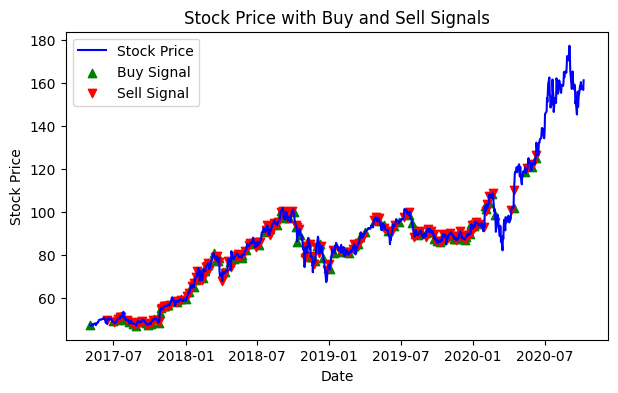

Total Returns: 33.30%
Final Portfolio Value: 13329.520434739366
Total Profit: 3329.5204347393665
Sharpe Ratio: 0.8368367985501641
Maximum Drawdown: -0.19619487540705227
Number of Trades Executed: 143
Win Ratio: 56.64%


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

signal = y_pred_best

# Implementing the trading strategy
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
position_open = False
position_price = 0
total_profit = 0
shares_held = 0
buy = []
sell = []
profits = []
trade_outcomes = []

# For plotting the results
buy_signals = []
sell_signals = []

for i in range(len(signal)):
    # Check if we have a predicted increase and no open position
    if signal[i] == 1 and not position_open:
        shares_held = balance / filtered_df['Open'][i]
        position_open = True
        position_price = filtered_df['Open'][i]
        buy_signals.append((filtered_df['Date'][i], position_price))
        buy.append(position_price)
        sell.append(np.nan)
        print(f"Buy at {position_price}")

    # Check if we have a predicted decrease and an open position
    elif signal[i] == 0 and position_open:
        position_open = False
        sell_price = filtered_df['Open'][i]
        profit = shares_held * (sell_price - position_price)
        total_profit += profit
        balance += profit
        shares_held = 0
        sell_signals.append((filtered_df['Date'][i], sell_price))
        sell.append(sell_price)
        buy.append(np.nan)
        profits.append(profit)
        trade_outcomes.append(1 if profit > 0 else 0)
        print(f"Sell at {sell_price}, Profit: {profit}")
    else:
        buy.append(np.nan)
        sell.append(np.nan)

# Print the final balance and total profit
print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {balance}")
print(f"Total Profit: {total_profit}")


# Plot the stock price along with buy and sell signals
plt.figure(figsize=(7, 4))
plt.plot(filtered_df['Date'], filtered_df['Open'], label='Stock Price', color='blue')
plt.scatter(*zip(*buy_signals), label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(*zip(*sell_signals), label='Sell Signal', marker='v', color='red', alpha=1)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price with Buy and Sell Signals')
plt.legend()
plt.show()

# Calculate returns
returns = (balance - initial_balance) / initial_balance
print(f"Total Returns: {returns * 100:.2f}%")

# Final Portfolio Value
if position_open:
    final_portfolio_value = balance + (shares_held * filtered_df['Open'].iloc[-1])
else:
    final_portfolio_value = balance

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Total Profit: {final_portfolio_value - initial_balance}")

# Calculate the Sharpe Ratio
returns_series = pd.Series(profits)
sharpe_ratio = returns_series.mean() / returns_series.std() * np.sqrt(len(profits))
print(f"Sharpe Ratio: {sharpe_ratio}")

# Calculate Maximum Drawdown
portfolio_values = [initial_balance] + [initial_balance + sum(profits[:i+1]) for i in range(len(profits))]
portfolio_values = pd.Series(portfolio_values)
rolling_max = portfolio_values.cummax()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
print(f"Maximum Drawdown: {max_drawdown}")

# Number of trades executed
num_trades = len(profits)
print(f"Number of Trades Executed: {num_trades}")

# Win Ratio
win_ratio = np.mean(trade_outcomes)
print(f"Win Ratio: {win_ratio * 100:.2f}%")


Web Scrapping for Microsoft

In [82]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import yfinance as yf

def fetch_headlines_and_dates(page_number):
    url = f"https://markets.businessinsider.com/news/msft-stock?p={page_number}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    for attempt in range(3):  # Try 3 times before giving up
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                headlines_and_dates = []
                news_items = soup.find_all('div', class_='latest-news__story')  # Adjust based on the actual structure of the news items
                for item in news_items:
                    headline_tag = item.find('a', class_='news-link')
                    if headline_tag:
                        headline = headline_tag.get_text(strip=True)
                        date_tag = item.find('time', class_='latest-news__date')
                        if date_tag and date_tag.has_attr('datetime'):
                            full_datetime = date_tag['datetime']
                            date = full_datetime.split(' ')[0]  # Extract the date part only
                            headlines_and_dates.append((date, headline))
                return headlines_and_dates
            else:
                print(f"Failed to fetch page {page_number}, status code: {response.status_code}")
        except requests.RequestException as e:
            print(f"Error fetching page {page_number}: {e}")
        time.sleep(5)  # Wait 5 seconds before retrying
    return []

def calculate_moving_averages(prices, window):
    return prices.rolling(window=window).mean()

In [83]:
    all_headlines_and_dates = []
    for page in range(1, 201):  # Loop through 201 pages for training the data and remaining for testing the data later
        print(f"Fetching page {page}")
        headlines_and_dates = fetch_headlines_and_dates(page)
        if headlines_and_dates:
            all_headlines_and_dates.extend(headlines_and_dates)
        else:
            print(f"No data fetched for page {page}, stopping.")
            break
        time.sleep(1)  # Wait 1 second between requests

Fetching page 1
Fetching page 2
Fetching page 3
Fetching page 4
Fetching page 5
Fetching page 6
Fetching page 7
Fetching page 8
Fetching page 9
Fetching page 10
Fetching page 11
Fetching page 12
Fetching page 13
Fetching page 14
Fetching page 15
Fetching page 16
Fetching page 17
Fetching page 18
Fetching page 19
Fetching page 20
Fetching page 21
Fetching page 22
Fetching page 23
Fetching page 24
Fetching page 25
Fetching page 26
Fetching page 27
Fetching page 28
Fetching page 29
Fetching page 30
Fetching page 31
Fetching page 32
Fetching page 33
Fetching page 34
Fetching page 35
Fetching page 36
Fetching page 37
Fetching page 38
Fetching page 39
Fetching page 40
Fetching page 41
Fetching page 42
Fetching page 43
Fetching page 44
Fetching page 45
Fetching page 46
Fetching page 47
Fetching page 48
Fetching page 49
Fetching page 50
Fetching page 51
Fetching page 52
Fetching page 53
Fetching page 54
Fetching page 55
Fetching page 56
Fetching page 57
Fetching page 58
Fetching page 59
Fetchi

In [84]:
import pandas as pd
import yfinance as yf

# Convert to DataFrame
df = pd.DataFrame(all_headlines_and_dates, columns=["Date", "Headline"])
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure proper order
df.sort_values('Date', inplace=True)

# Preprocess headlines
df['Cleaned_Headline'] = df['Headline'].apply(preprocess_text)

# Fetch stock data using yfinance
stock_data = yf.download('MSFT', start=df['Date'].min(), end=df['Date'].max() + pd.Timedelta(days=1))
stock_data.reset_index(inplace=True)

# Calculate moving averages and volatility
stock_data['7_day_MA'] = calculate_moving_averages(stock_data['Close'], 7)
stock_data['30_day_MA'] = calculate_moving_averages(stock_data['Close'], 30)
stock_data['Volatility'] = stock_data['Close'].rolling(window=7).std()

# Create a dictionary to hold headlines for each date
date_to_headlines = df.groupby('Date')['Cleaned_Headline'].apply('.'.join).to_dict()

# Initialize a list to hold merged headlines
merged_headlines = []

# Track the last trading date
last_trading_date = None

# Iterate through the date range
for current_date in pd.date_range(start=df['Date'].min(), end=df['Date'].max()):
    if current_date in stock_data['Date'].values:
        # If current date is a trading day, record it and append its headlines
        last_trading_date = current_date
        headline = date_to_headlines.get(current_date, '')
        merged_headlines.append({'Date': current_date, 'Headline': headline})
    else:
        # If current date is not a trading day, append its headlines to the last trading day
        if last_trading_date is not None:
            # Find the last trading day entry in merged_headlines and update its headline
            for entry in merged_headlines:
                if entry['Date'] == last_trading_date:
                    entry['Headline'] += '.' + date_to_headlines.get(current_date, '')

# Create a DataFrame for merged headlines
merged_df = pd.DataFrame(merged_headlines)

# Extract features from merged headlines
features_df = extract_features(merged_df['Headline'])

# Merge headlines with stock data
merged_df = pd.merge(merged_df, stock_data, left_on='Date', right_on='Date')

# Merge the extracted features
merged_df = pd.concat([merged_df, features_df], axis=1)

# Remove rows where markets are closed (if any)
merged_df = merged_df.dropna(subset=['Close'])

# Add label column
merged_df['Label'] = (merged_df['Close'].shift(-1) > merged_df['Close']).astype(int)

# Reset index
merged_df.reset_index(drop=True, inplace=True)

# Output the final merged DataFrame
merged_df


[*********************100%%**********************]  1 of 1 completed


,Date,Headline,Open,High,Low,Close,Adj Close,Volume,7_day_MA,30_day_MA,...,2,3,4,5,6,compound,neg,neu,pos,Label
0,2019-05-02,microsoft unveil new azur servic develop quick...,127.980003,128.000000,125.519997,126.209999,120.138336,27350200,NaN,NaN,...,0.015915,0.015913,0.015926,0.015883,0.904573,0.0000,0.000,1.000,0.000,1
1,2019-05-03,microsoft partner jpmorgan chase blockchain pr...,127.360001,129.429993,127.250000,128.899994,122.698906,24911100,NaN,NaN,...,0.017896,0.258671,0.651899,0.017860,0.017911,0.0000,0.000,1.000,0.000,0
2,2019-05-06,microsoft tea futurist new way play minecraft ...,126.389999,128.559998,126.110001,128.149994,121.984985,24239800,NaN,NaN,...,0.011943,0.011946,0.011948,0.011947,0.928364,0.5859,0.111,0.602,0.287,0
3,2019-05-07,,126.459999,127.180000,124.220001,125.519997,119.481514,36017700,NaN,NaN,...,0.142857,0.142857,0.142857,0.142857,0.142857,0.0000,0.000,0.000,0.000,0
4,2019-05-08,photo googl microsoft ceo show far taken rival...,125.440002,126.370003,124.750000,125.510002,119.472015,28419000,NaN,NaN,...,0.015934,0.015908,0.015923,0.015900,0.904518,0.0000,0.000,1.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,2024-06-12,appl overtak microsoft return world valuabl co...,435.320007,443.399994,433.250000,441.059998,441.059998,22366200,427.151428,419.647000,...,0.743163,0.000595,0.000595,0.000596,0.000595,0.9920,0.006,0.821,0.173,1
1288,2024-06-13,3 ai stock worthi challeng nvidia.tech ai driv...,440.850006,443.390015,439.369995,441.579987,441.579987,15960600,430.795711,421.201666,...,0.992710,0.001216,0.001215,0.001216,0.001214,0.9661,0.027,0.796,0.177,1
1289,2024-06-14,microsoft delay releas recal featur secur conc...,438.279999,443.140015,436.720001,442.570007,442.570007,13582000,433.447139,422.692667,...,0.784035,0.018601,0.001293,0.001293,0.001292,0.9337,0.048,0.799,0.152,1
1290,2024-06-17,tyler technolog ride grow custom base.microsof...,442.589996,450.940002,440.720001,448.369995,448.369995,20790000,436.854283,424.083000,...,0.988057,0.001989,0.001994,0.001989,0.001991,0.0000,0.000,1.000,0.000,0


In [85]:
# Filter out rows with headlines containing at least one alphabetic character or at least one numeric character
filtered_df = merged_df[merged_df['Headline'].str.contains('[a-zA-Z]|\d', regex=True)]

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

# Define features and target
X = filtered_df.drop(columns=[ 'Label','Date', 'Headline'])
y = filtered_df['Label']

# Handle any remaining NaN values
X = X.fillna(X.mean())

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
filtered_df

In [36]:
t=filtered_df.to_csv('v.csv')

Accuracy: 0.48828125
Precision: 0.5170454545454546
Recall: 0.6642335766423357
F1-Score: 0.5814696485623003
[[34 85]
 [46 91]]
              precision    recall  f1-score   support

           0       0.42      0.29      0.34       119
           1       0.52      0.66      0.58       137

    accuracy                           0.49       256
   macro avg       0.47      0.47      0.46       256
weighted avg       0.47      0.49      0.47       256



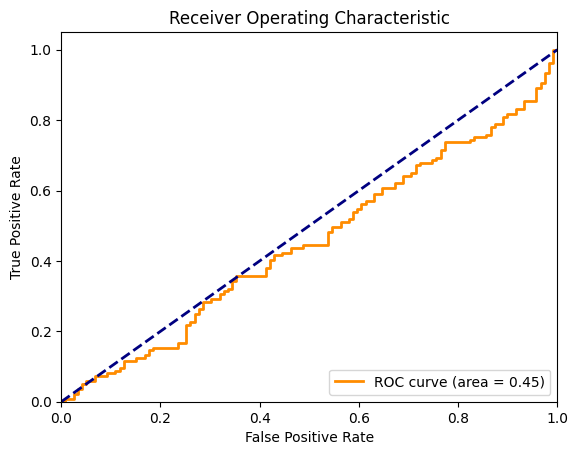

In [86]:
    # Train the logistic regression model

    model1.fit(X_train, y_train)

    # Make predictions
    y_pred1 = model1.predict(X_test)
    y_pred_prob1 = model1.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred1)}")
    print(f"Precision: {precision_score(y_test, y_pred1)}")
    print(f"Recall: {recall_score(y_test, y_pred1)}")
    print(f"F1-Score: {f1_score(y_test, y_pred1)}")
    print(confusion_matrix(y_test, y_pred1))
    print(classification_report(y_test, y_pred1))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


Accuracy: 0.50390625
Precision: 0.5297619047619048
Recall: 0.6496350364963503
F1-Score: 0.5836065573770493
[[40 79]
 [48 89]]
              precision    recall  f1-score   support

           0       0.45      0.34      0.39       119
           1       0.53      0.65      0.58       137

    accuracy                           0.50       256
   macro avg       0.49      0.49      0.49       256
weighted avg       0.49      0.50      0.49       256



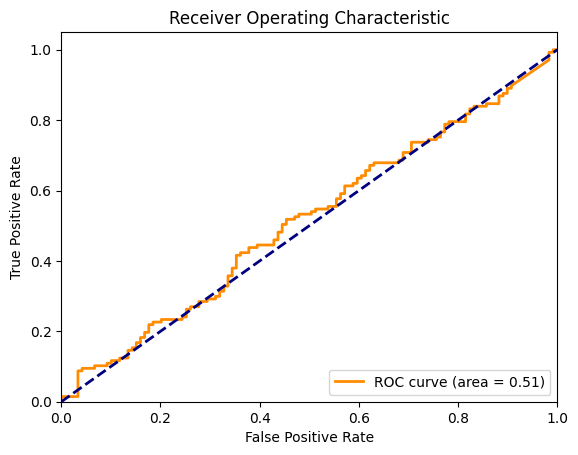

In [87]:

    model2.fit(X_train, y_train)

    # Make predictions
    y_pred2 = model2.predict(X_test)
    y_pred_prob2 = model2.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred2)}")
    print(f"Precision: {precision_score(y_test, y_pred2)}")
    print(f"Recall: {recall_score(y_test, y_pred2)}")
    print(f"F1-Score: {f1_score(y_test, y_pred2)}")
    print(confusion_matrix(y_test, y_pred2))
    print(classification_report(y_test, y_pred2))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob2)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.515625
Precision: 0.5436241610738255
Recall: 0.5912408759124088
F1-Score: 0.5664335664335665
[[51 68]
 [56 81]]
              precision    recall  f1-score   support

           0       0.48      0.43      0.45       119
           1       0.54      0.59      0.57       137

    accuracy                           0.52       256
   macro avg       0.51      0.51      0.51       256
weighted avg       0.51      0.52      0.51       256



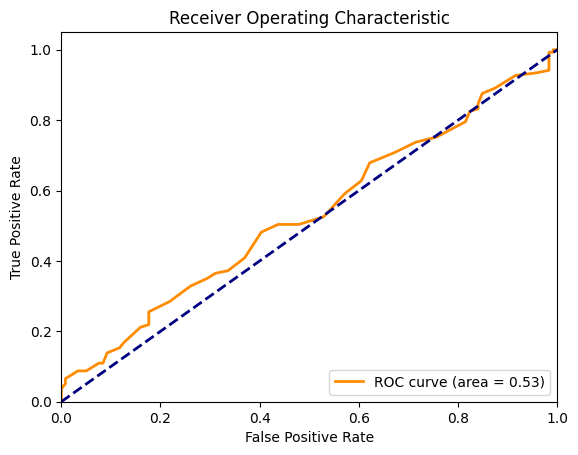

In [88]:
    model3.fit(X_train, y_train)

    # Make predictions
    y_pred3 = model3.predict(X_test)
    y_pred_prob3 = model3.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred3)}")
    print(f"Precision: {precision_score(y_test, y_pred3)}")
    print(f"Recall: {recall_score(y_test, y_pred3)}")
    print(f"F1-Score: {f1_score(y_test, y_pred3)}")
    print(confusion_matrix(y_test, y_pred3))
    print(classification_report(y_test, y_pred3))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob3)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.5344827586206896
Precision: 0.5166666666666667
Recall: 0.5535714285714286
F1-Score: 0.5344827586206896
[[31 29]
 [25 31]]
              precision    recall  f1-score   support

           0       0.55      0.52      0.53        60
           1       0.52      0.55      0.53        56

    accuracy                           0.53       116
   macro avg       0.54      0.54      0.53       116
weighted avg       0.54      0.53      0.53       116



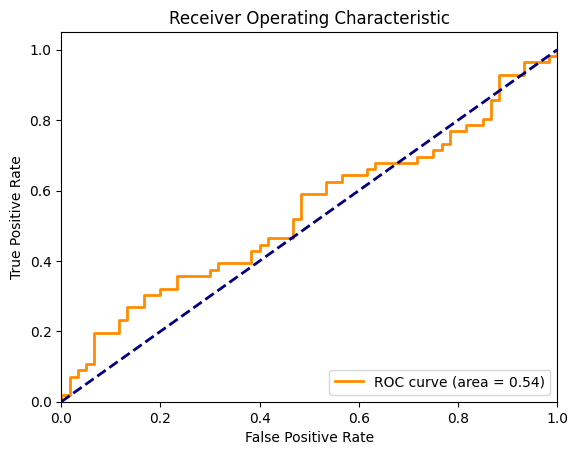

In [117]:

    # Train the model
    model4.fit(X_train, y_train)

    # Make predictions
    y_pred4 = model4.predict(X_test)
    y_pred_prob4 = model4.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred4)}")
    print(f"Precision: {precision_score(y_test, y_pred4)}")
    print(f"Recall: {recall_score(y_test, y_pred4)}")
    print(f"F1-Score: {f1_score(y_test, y_pred4)}")
    print(confusion_matrix(y_test, y_pred4))
    print(classification_report(y_test, y_pred4))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob4)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Finding the best Model


In [91]:
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)
accuracy3 = accuracy_score(y_test, y_pred3)
accuracy4 = accuracy_score(y_test, y_pred4)
accuracies = {
    'Logistic Regression': accuracy1,
    'SVM': accuracy2,
    'Random Forest': accuracy3,
    'Neural Network': accuracy4
}
#Best model will be the one which have high accuracy
best_model_name = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model_name]

print(f"Best model: {best_model_name} with accuracy: {best_accuracy}")

# Store the best model for future use
if best_model_name == 'Logistic Regression':
    best_model = model1
elif best_model_name == 'SVM':
    best_model = model2
elif best_model_name == 'Random Forest':
    best_model = model3
else:
    best_model = model4

Best model: Random Forest with accuracy: 0.515625


In [92]:
    headlines_test = []
    for page in range(201, 252):  # Loop through remaining pages for using it in further strategy(i.e backtesting)
        print(f"Fetching page {page}")
        headlines_and_dates = fetch_headlines_and_dates(page)
        if headlines_and_dates:
            headlines_test.extend(headlines_and_dates)
        else:
            print(f"No data fetched for page {page}, stopping.")
            break
        time.sleep(1)  # Wait 1 second between requests

Fetching page 201
Fetching page 202
Fetching page 203
Fetching page 204
Fetching page 205
Fetching page 206
Fetching page 207
Fetching page 208
Fetching page 209
Fetching page 210
Fetching page 211
Fetching page 212
Fetching page 213
Fetching page 214
Fetching page 215
Fetching page 216
Fetching page 217
Fetching page 218
Fetching page 219
Fetching page 220
Fetching page 221
Fetching page 222
Fetching page 223
Fetching page 224
Fetching page 225
Fetching page 226
Fetching page 227
Fetching page 228
Fetching page 229
Fetching page 230
Fetching page 231
Fetching page 232
Fetching page 233
Fetching page 234
Fetching page 235
Fetching page 236
Fetching page 237
Fetching page 238
Fetching page 239
Fetching page 240
Fetching page 241
Fetching page 242
Fetching page 243
Fetching page 244
Fetching page 245
Fetching page 246
Fetching page 247
Fetching page 248
Fetching page 249
Fetching page 250
Fetching page 251


In [93]:
import pandas as pd
import yfinance as yf

# Convert to DataFrame
df = pd.DataFrame(headlines_test, columns=["Date", "Headline"])
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure proper order
df.sort_values('Date', inplace=True)

# Preprocess headlines
df['Cleaned_Headline'] = df['Headline'].apply(preprocess_text)

# Fetch stock data using yfinance
stock_data = yf.download('MSFT', start=df['Date'].min(), end=df['Date'].max() + pd.Timedelta(days=1))
stock_data.reset_index(inplace=True)

# Calculate moving averages and volatility
stock_data['7_day_MA'] = calculate_moving_averages(stock_data['Close'], 7)
stock_data['30_day_MA'] = calculate_moving_averages(stock_data['Close'], 30)
stock_data['Volatility'] = stock_data['Close'].rolling(window=7).std()

# Create a dictionary to hold headlines for each date
date_to_headlines = df.groupby('Date')['Cleaned_Headline'].apply('.'.join).to_dict()

# Initialize a list to hold merged headlines
merged_headlines = []

# Track the last trading date
last_trading_date = None

# Iterate through the date range
for current_date in pd.date_range(start=df['Date'].min(), end=df['Date'].max()):
    if current_date in stock_data['Date'].values:
        # If current date is a trading day, record it and append its headlines
        last_trading_date = current_date
        headline = date_to_headlines.get(current_date, '')
        merged_headlines.append({'Date': current_date, 'Headline': headline})
    else:
        # If current date is not a trading day, append its headlines to the last trading day
        if last_trading_date is not None:
            # Find the last trading day entry in merged_headlines and update its headline
            for entry in merged_headlines:
                if entry['Date'] == last_trading_date:
                    entry['Headline'] += '.' + date_to_headlines.get(current_date, '')

# Create a DataFrame for merged headlines
merged_df2 = pd.DataFrame(merged_headlines)

# Extract features from merged headlines
features_df = extract_features(merged_df2['Headline'])

# Merge headlines with stock data
merged_df2 = pd.merge(merged_df2, stock_data, left_on='Date', right_on='Date')

# Merge the extracted features
merged_df2 = pd.concat([merged_df2, features_df], axis=1)

# Remove rows where markets are closed (if any)
merged_df2 = merged_df2.dropna(subset=['Close'])


# Reset index
merged_df2.reset_index(drop=True, inplace=True)

# Output the final merged DataFrame
merged_df2


[*********************100%%**********************]  1 of 1 completed


,Date,Headline,Open,High,Low,Close,Adj Close,Volume,7_day_MA,30_day_MA,...,1,2,3,4,5,6,compound,neg,neu,pos
0,2011-05-24,microsoft appeal eu antitrust fine,24.200001,24.290001,24.040001,24.150000,18.897625,47691800,NaN,NaN,...,0.023938,0.384998,0.023932,0.495597,0.023862,0.023841,0.2023,0.000,0.690,0.310
1,2011-05-25,,24.170000,24.309999,24.160000,24.190001,18.928930,34904200,NaN,NaN,...,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.0000,0.000,0.000,0.000
2,2011-05-26,hedg fund star call microsoft ceo go.microsoft...,24.350000,25.030001,24.320000,24.670000,19.304529,78016600,NaN,NaN,...,0.010222,0.010229,0.010220,0.010232,0.938646,0.010222,0.2960,0.000,0.833,0.167
3,2011-05-27,microsoft board back ballmer einhorn.come next...,24.680000,24.900000,24.650000,24.760000,19.374956,50251000,NaN,NaN,...,0.011977,0.368845,0.011930,0.011953,0.296123,0.287220,0.0000,0.000,1.000,0.000
4,2011-05-31,,24.959999,25.059999,24.700001,25.010000,19.570587,60196300,NaN,NaN,...,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.0000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,2019-04-26,industri leader like bill gate elon musk took ...,129.699997,130.520004,129.020004,129.889999,123.641296,23654900,125.484286,120.381667,...,0.008948,0.690091,0.265194,0.008948,0.008935,0.008937,0.3612,0.000,0.878,0.122
1994,2019-04-29,melinda gate shock bill quit high power micros...,129.899994,130.179993,129.350006,129.770004,123.527077,16324200,126.627144,120.843667,...,0.004218,0.126477,0.342604,0.004220,0.173541,0.004222,-0.3818,0.067,0.933,0.000
1995,2019-04-30,10 best book technolog accord bill gate,129.809998,130.699997,129.389999,130.600006,124.317131,24166500,127.660001,121.278001,...,0.017876,0.017859,0.892750,0.017887,0.017886,0.017870,0.6369,0.000,0.588,0.412
1996,2019-05-01,,130.529999,130.649994,127.699997,127.879997,121.727989,26821700,128.248572,121.619000,...,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.0000,0.000,0.000,0.000


In [94]:
# Filter out rows with headlines containing at least one alphabetic character or at least one numeric character(i.e empty)
filtered_df = merged_df2[merged_df2['Headline'].str.contains('[a-zA-Z]|\d', regex=True)]

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

X2 = filtered_df.drop(columns=[ 'Date', 'Headline',])
# Handle any remaining NaN values
X2 = X2.fillna(X2.mean())

# Ensure all column names are strings
X2.columns = X2.columns.astype(str)
X2.reset_index(drop=True, inplace=True)
scaler = StandardScaler()
X2= scaler.fit_transform(X2)


y_pred_best=best_model.predict(X2)


In [45]:
filtered_df

,Date,Headline,Open,High,Low,Close,Adj Close,Volume,7_day_MA,30_day_MA,...,1,2,3,4,5,6,compound,neg,neu,pos
0,2011-05-24,microsoft appeal eu antitrust fine,24.200001,24.290001,24.040001,24.150000,18.897625,47691800,NaN,NaN,...,0.023938,0.384998,0.023932,0.495597,0.023862,0.023841,0.2023,0.000,0.690,0.310
1,2011-05-26,hedg fund star call microsoft ceo go.microsoft...,24.350000,25.030001,24.320000,24.670000,19.304529,78016600,NaN,NaN,...,0.010222,0.010229,0.010220,0.010232,0.938646,0.010222,0.2960,0.000,0.833,0.167
2,2011-05-27,microsoft board back ballmer einhorn.come next...,24.680000,24.900000,24.650000,24.760000,19.374956,50251000,NaN,NaN,...,0.011977,0.368845,0.011930,0.011953,0.296123,0.287220,0.0000,0.000,1.000,0.000
3,2011-06-01,nokia call report microsoft deal baseless,24.990000,25.100000,24.370001,24.430000,19.116724,74033500,NaN,NaN,...,0.023861,0.856806,0.023868,0.023842,0.023932,0.023838,0.0000,0.000,1.000,0.000
4,2011-06-02,microsoft show new window 8 oper system,24.490000,24.650000,24.180000,24.219999,18.952406,51487800,24.490000,NaN,...,0.020484,0.020459,0.020475,0.877240,0.020466,0.020445,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,2019-04-25,u stock p 500 flat loss industri offset gain f...,130.059998,131.369995,128.830002,129.149994,122.936882,38033900,124.181428,119.871667,...,0.001910,0.095454,0.326296,0.279962,0.001909,0.001913,0.8176,0.075,0.756,0.169
765,2019-04-26,industri leader like bill gate elon musk took ...,129.699997,130.520004,129.020004,129.889999,123.641296,23654900,125.484286,120.381667,...,0.008948,0.690091,0.265194,0.008948,0.008935,0.008937,0.3612,0.000,0.878,0.122
766,2019-04-29,melinda gate shock bill quit high power micros...,129.899994,130.179993,129.350006,129.770004,123.527077,16324200,126.627144,120.843667,...,0.004218,0.126477,0.342604,0.004220,0.173541,0.004222,-0.3818,0.067,0.933,0.000
767,2019-04-30,10 best book technolog accord bill gate,129.809998,130.699997,129.389999,130.600006,124.317131,24166500,127.660001,121.278001,...,0.017876,0.017859,0.892750,0.017887,0.017886,0.017870,0.6369,0.000,0.588,0.412


Buy at 24.489999771118164
Sell at 31.450000762939453, Profit: 2841.976748415261
Buy at 29.479999542236328
Sell at 31.0, Profit: 662.1374097450503
Buy at 30.760000228881836
Sell at 30.219999313354492, Profit: -237.06872413951913
Buy at 29.809999465942383
Sell at 29.049999237060547, Profit: -338.24078319629604
Buy at 28.190000534057617
Sell at 28.729999542236328, Profit: 247.6602183794504
Buy at 28.950000762939453
Sell at 34.84000015258789, Profit: 2680.807184526486
Buy at 34.9900016784668
Sell at 34.75, Profit: -108.7674114386238
Buy at 34.40999984741211
Sell at 35.16999816894531, Profit: 347.8301990082624
Buy at 34.400001525878906
Sell at 37.349998474121094, Profit: 1380.3528067868713
Buy at 36.849998474121094
Sell at 37.220001220703125, Profit: 175.47958476822322
Buy at 36.33000183105469
Sell at 36.290000915527344, Profit: -19.435805526230716
Buy at 35.79999923706055
Sell at 40.34000015258789, Profit: 2236.10666283059
Buy at 39.7400016784668
Sell at 39.7400016784668, Profit: 0.0
Buy a

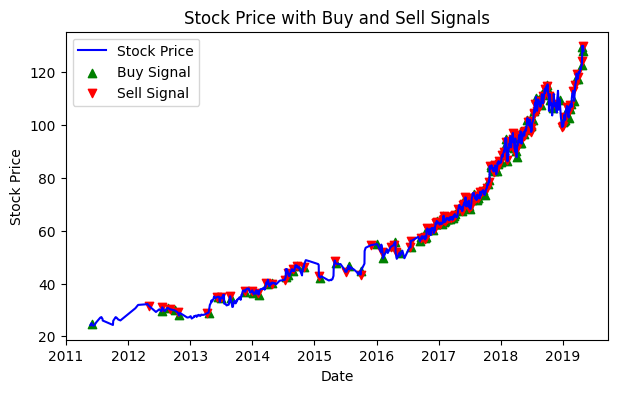

Total Returns: 342.94%
Final Portfolio Value: 88587.3963175992
Total Profit: 78587.3963175992
Sharpe Ratio: 2.626324016907898
Maximum Drawdown: -0.172603775710283
Number of Trades Executed: 137
Win Ratio: 62.04%


In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

signal = y_pred_best

# Implementing the trading strategy
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
position_open = False
position_price = 0
total_profit = 0
shares_held = 0
buy = []
sell = []
profits = []
trade_outcomes = []

# For plotting the results
buy_signals = []
sell_signals = []

for i in range(len(signal)):
    # Check if we have a predicted increase and no open position
    if signal[i] == 1 and not position_open:
        shares_held = balance / filtered_df['Open'][i]
        position_open = True
        position_price = filtered_df['Open'][i]
        buy_signals.append((filtered_df['Date'][i], position_price))
        buy.append(position_price)
        sell.append(np.nan)
        print(f"Buy at {position_price}")

    # Check if we have a predicted decrease and an open position
    elif signal[i] == 0 and position_open:
        position_open = False
        sell_price = filtered_df['Open'][i]
        profit = shares_held * (sell_price - position_price)
        total_profit += profit
        balance += profit
        shares_held = 0
        sell_signals.append((filtered_df['Date'][i], sell_price))
        sell.append(sell_price)
        buy.append(np.nan)
        profits.append(profit)
        trade_outcomes.append(1 if profit > 0 else 0)
        print(f"Sell at {sell_price}, Profit: {profit}")
    else:
        buy.append(np.nan)
        sell.append(np.nan)

# Print the final balance and total profit
print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {balance}")
print(f"Total Profit: {total_profit}")



# Plot the stock price along with buy and sell signals
plt.figure(figsize=(7, 4))
plt.plot(filtered_df['Date'], filtered_df['Open'], label='Stock Price', color='blue')
plt.scatter(*zip(*buy_signals), label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(*zip(*sell_signals), label='Sell Signal', marker='v', color='red', alpha=1)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price with Buy and Sell Signals')
plt.legend()
plt.show()

# Calculate returns
returns = (balance - initial_balance) / initial_balance
print(f"Total Returns: {returns * 100:.2f}%")

# Final Portfolio Value
if position_open:
    final_portfolio_value = balance + (shares_held * filtered_df['Open'].iloc[-1])
else:
    final_portfolio_value = balance

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Total Profit: {final_portfolio_value - initial_balance}")

# Calculate the Sharpe Ratio
returns_series = pd.Series(profits)
sharpe_ratio = returns_series.mean() / returns_series.std() * np.sqrt(len(profits))
print(f"Sharpe Ratio: {sharpe_ratio}")

# Calculate Maximum Drawdown
portfolio_values = [initial_balance] + [initial_balance + sum(profits[:i+1]) for i in range(len(profits))]
portfolio_values = pd.Series(portfolio_values)
rolling_max = portfolio_values.cummax()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
print(f"Maximum Drawdown: {max_drawdown}")

# Number of trades executed
num_trades = len(profits)
print(f"Number of Trades Executed: {num_trades}")

# Win Ratio
win_ratio = np.mean(trade_outcomes)
print(f"Win Ratio: {win_ratio * 100:.2f}%")


Web scrapping For Tesla

In [96]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import yfinance as yf

def fetch_headlines_and_dates(page_number):
    url = f"https://markets.businessinsider.com/news/tsla-stock?p={page_number}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    for attempt in range(3):  # Try 3 times before giving up
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                headlines_and_dates = []
                news_items = soup.find_all('div', class_='latest-news__story')  # Adjust based on the actual structure of the news items
                for item in news_items:
                    headline_tag = item.find('a', class_='news-link')
                    if headline_tag:
                        headline = headline_tag.get_text(strip=True)
                        date_tag = item.find('time', class_='latest-news__date')
                        if date_tag and date_tag.has_attr('datetime'):
                            full_datetime = date_tag['datetime']
                            date = full_datetime.split(' ')[0]  # Extract the date part only
                            headlines_and_dates.append((date, headline))
                return headlines_and_dates
            else:
                print(f"Failed to fetch page {page_number}, status code: {response.status_code}")
        except requests.RequestException as e:
            print(f"Error fetching page {page_number}: {e}")
        time.sleep(5)  # Wait 5 seconds before retrying
    return []

def calculate_moving_averages(prices, window):
    return prices.rolling(window=window).mean()

In [97]:
    all_headlines_and_dates = []
    for page in range(1, 201):  # Loop through 201 pages for training the data and remaining for testing the data later
        print(f"Fetching page {page}")
        headlines_and_dates = fetch_headlines_and_dates(page)
        if headlines_and_dates:
            all_headlines_and_dates.extend(headlines_and_dates)
        else:
            print(f"No data fetched for page {page}, stopping.")
            break
        time.sleep(1)  # Wait 1 second between requests

Fetching page 1
Fetching page 2
Fetching page 3
Fetching page 4
Fetching page 5
Fetching page 6
Fetching page 7
Fetching page 8
Fetching page 9
Fetching page 11
Fetching page 12
Fetching page 13
Fetching page 14
Fetching page 15
Fetching page 16
Fetching page 17
Fetching page 18
Fetching page 19
Fetching page 20
Fetching page 21
Fetching page 22
Fetching page 23
Fetching page 24
Fetching page 25
Fetching page 26
Fetching page 27
Fetching page 28
Fetching page 29
Fetching page 30
Fetching page 31
Fetching page 32
Fetching page 33
Fetching page 34
Fetching page 35
Fetching page 36
Fetching page 37
Fetching page 38
Fetching page 39
Fetching page 40
Fetching page 41
Fetching page 42
Fetching page 43
Fetching page 44
Fetching page 45
Fetching page 46
Fetching page 47
Fetching page 48
Fetching page 49
Fetching page 50
Fetching page 51
Fetching page 52
Fetching page 53
Fetching page 54
Fetching page 55
Fetching page 56
Fetching page 57
Fetching page 58
Fetching page 59
Fetching page 60
Fetchi

In [98]:
import pandas as pd
import yfinance as yf

# Convert to DataFrame
df = pd.DataFrame(all_headlines_and_dates, columns=["Date", "Headline"])
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure proper order
df.sort_values('Date', inplace=True)

# Preprocess headlines
df['Cleaned_Headline'] = df['Headline'].apply(preprocess_text)

# Fetch stock data using yfinance
stock_data = yf.download('TSLA', start=df['Date'].min(), end=df['Date'].max() + pd.Timedelta(days=1))
stock_data.reset_index(inplace=True)

# Calculate moving averages and volatility
stock_data['7_day_MA'] = calculate_moving_averages(stock_data['Close'], 7)
stock_data['30_day_MA'] = calculate_moving_averages(stock_data['Close'], 30)
stock_data['Volatility'] = stock_data['Close'].rolling(window=7).std()

# Create a dictionary to hold headlines for each date
date_to_headlines = df.groupby('Date')['Cleaned_Headline'].apply('.'.join).to_dict()

# Initialize a list to hold merged headlines
merged_headlines = []

# Track the last trading date
last_trading_date = None

# Iterate through the date range
for current_date in pd.date_range(start=df['Date'].min(), end=df['Date'].max()):
    if current_date in stock_data['Date'].values:
        # If current date is a trading day, record it and append its headlines
        last_trading_date = current_date
        headline = date_to_headlines.get(current_date, '')
        merged_headlines.append({'Date': current_date, 'Headline': headline})
    else:
        # If current date is not a trading day, append its headlines to the last trading day
        if last_trading_date is not None:
            # Find the last trading day entry in merged_headlines and update its headline
            for entry in merged_headlines:
                if entry['Date'] == last_trading_date:
                    entry['Headline'] += '.' + date_to_headlines.get(current_date, '')

# Create a DataFrame for merged headlines
merged_df = pd.DataFrame(merged_headlines)

# Extract features from merged headlines
features_df = extract_features(merged_df['Headline'])

# Merge headlines with stock data
merged_df = pd.merge(merged_df, stock_data, left_on='Date', right_on='Date')

# Merge the extracted features
merged_df = pd.concat([merged_df, features_df], axis=1)

# Remove rows where markets are closed (if any)
merged_df = merged_df.dropna(subset=['Close'])

# Add label column
merged_df['Label'] = (merged_df['Close'].shift(-1) > merged_df['Close']).astype(int)

# Drop unnecessary columns
# merged_df.drop(columns=['Cleaned_Headline'], inplace=True)

# Reset index
merged_df.reset_index(drop=True, inplace=True)

# Output the final merged DataFrame
merged_df


[*********************100%%**********************]  1 of 1 completed


,Date,Headline,Open,High,Low,Close,Adj Close,Volume,7_day_MA,30_day_MA,...,2,3,4,5,6,compound,neg,neu,pos,Label
0,2022-03-01,twitter ramp bitcoin ethereum relat offer enou...,289.893341,296.626678,284.593323,288.123322,288.123322,74766900,NaN,NaN,...,0.001662,0.001664,0.663031,0.001663,0.001668,0.8360,0.033,0.838,0.129,1
1,2022-03-02,36 stock watch biden first state union address...,290.709991,295.493347,281.423340,293.296661,293.296661,74643300,NaN,NaN,...,0.001223,0.001224,0.309811,0.001224,0.001227,0.9790,0.000,0.791,0.209,0
2,2022-03-03,elon musk explain tesla tri make world longest...,292.923340,295.480011,277.533325,279.763336,279.763336,61623600,NaN,NaN,...,0.001232,0.190822,0.001238,0.001235,0.001237,-0.3022,0.060,0.896,0.043,0
3,2022-03-04,fast charg evgo good busi wait becom profit.te...,283.033325,285.216675,275.053345,279.429993,279.429993,66999600,NaN,NaN,...,0.001135,0.001137,0.001140,0.001135,0.484772,-0.3400,0.058,0.902,0.040,0
4,2022-03-07,tsla stock clear path 1 400 berlin gigafactori...,285.433319,288.713318,268.190002,268.193329,268.193329,72494100,NaN,NaN,...,0.001245,0.001241,0.207700,0.001233,0.644285,-0.6249,0.074,0.891,0.034,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,2024-06-12,tesla sharehold meet 2024 preview watch elon m...,171.119995,180.550003,169.800003,177.289993,177.289993,90389400,175.275713,176.744000,...,0.000923,0.000924,0.905598,0.000923,0.000926,-0.0516,0.058,0.892,0.051,1
575,2024-06-13,william sonoma stock split mark calendar june ...,188.389999,191.080002,181.229996,182.470001,182.470001,118984100,176.375713,176.826667,...,0.000808,0.000810,0.688233,0.000809,0.221625,0.8481,0.047,0.885,0.068,0
576,2024-06-14,4 stock watch friday tsla pin.elon musk 56b pa...,185.800003,186.000000,176.919998,178.009995,178.009995,82038200,176.805712,176.760000,...,0.001459,0.001460,0.772456,0.001460,0.001463,0.9531,0.023,0.822,0.155,1
577,2024-06-17,tdk announc wearabl batteri breakthrough.broad...,177.919998,188.809998,177.000000,187.440002,187.440002,109786100,178.162855,176.968333,...,0.002384,0.002385,0.985652,0.002393,0.002396,0.9371,0.000,0.790,0.210,0


In [99]:
# Filter out rows with headlines containing at least one alphabetic character or at least one numeric character
filtered_df = merged_df[merged_df['Headline'].str.contains('[a-zA-Z]|\d', regex=True)]

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

# Define features and target
X = filtered_df.drop(columns=[ 'Label','Date', 'Headline'])
y = filtered_df['Label']

# Handle any remaining NaN values
X = X.fillna(X.mean())

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Accuracy: 0.5172413793103449
Precision: 0.5
Recall: 0.4642857142857143
F1-Score: 0.4814814814814815
[[34 26]
 [30 26]]
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        60
           1       0.50      0.46      0.48        56

    accuracy                           0.52       116
   macro avg       0.52      0.52      0.51       116
weighted avg       0.52      0.52      0.52       116



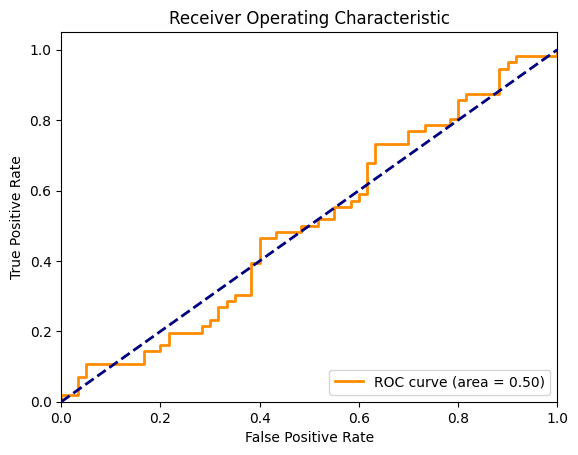

In [100]:

    model1.fit(X_train, y_train)

    # Make predictions
    y_pred1 = model1.predict(X_test)
    y_pred_prob1 = model1.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred1)}")
    print(f"Precision: {precision_score(y_test, y_pred1)}")
    print(f"Recall: {recall_score(y_test, y_pred1)}")
    print(f"F1-Score: {f1_score(y_test, y_pred1)}")
    print(confusion_matrix(y_test, y_pred1))
    print(classification_report(y_test, y_pred1))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


Accuracy: 0.49137931034482757
Precision: 0.4727272727272727
Recall: 0.4642857142857143
F1-Score: 0.4684684684684684
[[31 29]
 [30 26]]
              precision    recall  f1-score   support

           0       0.51      0.52      0.51        60
           1       0.47      0.46      0.47        56

    accuracy                           0.49       116
   macro avg       0.49      0.49      0.49       116
weighted avg       0.49      0.49      0.49       116



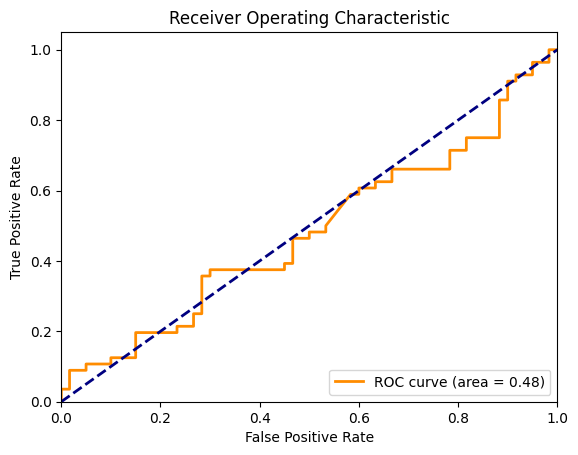

In [101]:

    model2.fit(X_train, y_train)

    # Make predictions
    y_pred2 = model2.predict(X_test)
    y_pred_prob2 = model2.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred2)}")
    print(f"Precision: {precision_score(y_test, y_pred2)}")
    print(f"Recall: {recall_score(y_test, y_pred2)}")
    print(f"F1-Score: {f1_score(y_test, y_pred2)}")
    print(confusion_matrix(y_test, y_pred2))
    print(classification_report(y_test, y_pred2))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob2)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.5603448275862069
Precision: 0.543859649122807
Recall: 0.5535714285714286
F1-Score: 0.5486725663716814
[[34 26]
 [25 31]]
              precision    recall  f1-score   support

           0       0.58      0.57      0.57        60
           1       0.54      0.55      0.55        56

    accuracy                           0.56       116
   macro avg       0.56      0.56      0.56       116
weighted avg       0.56      0.56      0.56       116



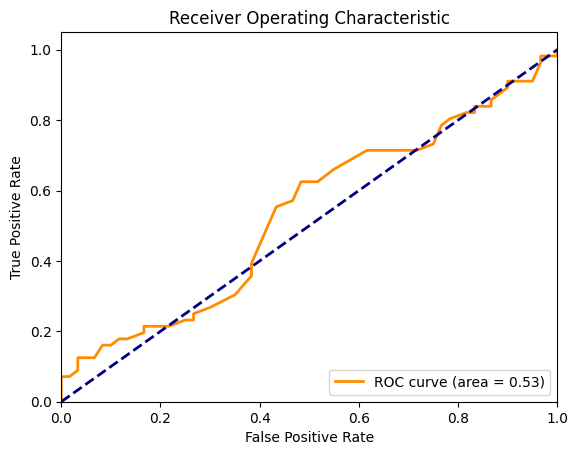

In [102]:

    model3.fit(X_train, y_train)

    # Make predictions
    y_pred3 = model3.predict(X_test)
    y_pred_prob3 = model3.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred3)}")
    print(f"Precision: {precision_score(y_test, y_pred3)}")
    print(f"Recall: {recall_score(y_test, y_pred3)}")
    print(f"F1-Score: {f1_score(y_test, y_pred3)}")
    print(confusion_matrix(y_test, y_pred3))
    print(classification_report(y_test, y_pred3))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob3)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.4827586206896552
Precision: 0.46153846153846156
Recall: 0.42857142857142855
F1-Score: 0.4444444444444445
[[32 28]
 [32 24]]
              precision    recall  f1-score   support

           0       0.50      0.53      0.52        60
           1       0.46      0.43      0.44        56

    accuracy                           0.48       116
   macro avg       0.48      0.48      0.48       116
weighted avg       0.48      0.48      0.48       116



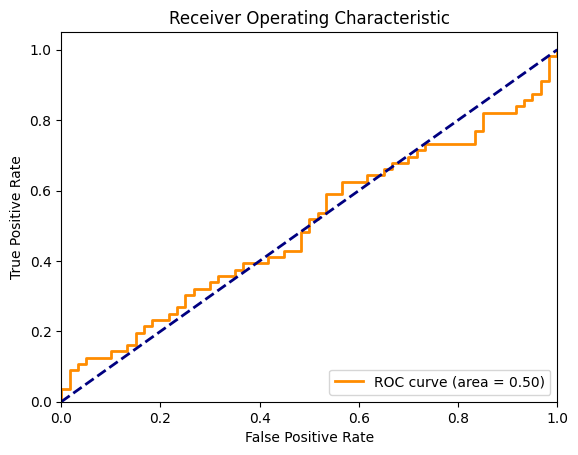

In [121]:



    # Train the model
    model4.fit(X_train, y_train)

    # Make predictions
    y_pred4 = model4.predict(X_test)
    y_pred_prob4 = model4.predict_proba(X_test)[:, 1]


    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred4)}")
    print(f"Precision: {precision_score(y_test, y_pred4)}")
    print(f"Recall: {recall_score(y_test, y_pred4)}")
    print(f"F1-Score: {f1_score(y_test, y_pred4)}")
    print(confusion_matrix(y_test, y_pred4))
    print(classification_report(y_test, y_pred4))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob4)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [119]:
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)
accuracy3 = accuracy_score(y_test, y_pred3)
accuracy4 = accuracy_score(y_test, y_pred4)
accuracies = {
    'Logistic Regression': accuracy1,
    'SVM': accuracy2,
    'Random Forest': accuracy3,
    'Neural Network': accuracy4
}

best_model_name = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model_name]

print(f"Best model: {best_model_name} with accuracy: {best_accuracy}")

# Optional: Store the best model for future use
if best_model_name == 'Logistic Regression':
    best_model = model1
elif best_model_name == 'SVM':
    best_model = model2
elif best_model_name == 'Random Forest':
    best_model = model3
else:
    best_model = model4

Best model: Random Forest with accuracy: 0.5603448275862069


In [105]:
    headlines_test = []
    for page in range(201, 401):  # Loop through remaining pages for using it in further strategy(i.e backtesting)
        print(f"Fetching page {page}")
        headlines_and_dates = fetch_headlines_and_dates(page)
        if headlines_and_dates:
            headlines_test.extend(headlines_and_dates)
        else:
            print(f"No data fetched for page {page}, stopping.")
            break
        time.sleep(1)  # Wait 1 second between requests

Fetching page 201
Fetching page 202
Fetching page 203
Fetching page 204
Fetching page 205
Fetching page 206
Fetching page 207
Fetching page 208
Fetching page 209
Fetching page 210
Fetching page 211
Fetching page 212
Fetching page 213
Fetching page 214
Fetching page 215
Fetching page 216
Fetching page 217
Fetching page 218
Fetching page 219
Fetching page 220
Fetching page 221
Fetching page 222
Fetching page 223
Fetching page 224
Fetching page 225
Fetching page 226
Fetching page 227
Fetching page 228
Fetching page 229
Fetching page 230
Fetching page 231
Fetching page 232
Fetching page 233
Fetching page 234
Fetching page 235
Fetching page 236
Fetching page 237
Fetching page 238
Fetching page 239
Fetching page 240
Fetching page 241
Fetching page 242
Fetching page 243
Fetching page 244
Fetching page 245
Fetching page 246
Fetching page 247
Fetching page 248
Fetching page 249
Fetching page 250
Fetching page 251
Fetching page 252
Fetching page 253
Fetching page 254
Fetching page 255
Fetching p

In [111]:
import pandas as pd
import yfinance as yf

# Convert to DataFrame
df = pd.DataFrame(headlines_test, columns=["Date", "Headline"])
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure proper order
df.sort_values('Date', inplace=True)

# Preprocess headlines
df['Cleaned_Headline'] = df['Headline'].apply(preprocess_text)

# Fetch stock data using yfinance
stock_data = yf.download('TSLA', start=df['Date'].min(), end=df['Date'].max() + pd.Timedelta(days=1))
stock_data.reset_index(inplace=True)

# Calculate moving averages and volatility
stock_data['7_day_MA'] = calculate_moving_averages(stock_data['Close'], 7)
stock_data['30_day_MA'] = calculate_moving_averages(stock_data['Close'], 30)
stock_data['Volatility'] = stock_data['Close'].rolling(window=7).std()

# Create a dictionary to hold headlines for each date
date_to_headlines = df.groupby('Date')['Cleaned_Headline'].apply('.'.join).to_dict()

# Initialize a list to hold merged headlines
merged_headlines = []

# Track the last trading date
last_trading_date = None

# Iterate through the date range
for current_date in pd.date_range(start=df['Date'].min(), end=df['Date'].max()):
    if current_date in stock_data['Date'].values:
        # If current date is a trading day, record it and append its headlines
        last_trading_date = current_date
        headline = date_to_headlines.get(current_date, '')
        merged_headlines.append({'Date': current_date, 'Headline': headline})
    else:
        # If current date is not a trading day, append its headlines to the last trading day
        if last_trading_date is not None:
            # Find the last trading day entry in merged_headlines and update its headline
            for entry in merged_headlines:
                if entry['Date'] == last_trading_date:
                    entry['Headline'] += '.' + date_to_headlines.get(current_date, '')

# Create a DataFrame for merged headlines
merged_df2 = pd.DataFrame(merged_headlines)

# Extract features from merged headlines
features_df = extract_features(merged_df2['Headline'])

# Merge headlines with stock data
merged_df2 = pd.merge(merged_df2, stock_data, left_on='Date', right_on='Date')

# Merge the extracted features
merged_df2 = pd.concat([merged_df2, features_df], axis=1)

# Remove rows where markets are closed (if any)
merged_df2 = merged_df2.dropna(subset=['Close'])


# Reset index
merged_df2.reset_index(drop=True, inplace=True)

# Output the final merged DataFrame
merged_df2


[*********************100%%**********************]  1 of 1 completed


,Date,Headline,Open,High,Low,Close,Adj Close,Volume,7_day_MA,30_day_MA,...,1,2,3,4,5,6,compound,neg,neu,pos
0,2019-04-04,tesla share skid first quarter deliveri disapp...,17.459333,18.080000,17.372667,17.851999,17.851999,355810500,NaN,NaN,...,0.000393,0.997645,0.000393,0.000392,0.000392,0.000392,-0.9942,0.204,0.682,0.114
1,2019-04-05,elon musk terribl week could easili get wors f...,17.990667,18.406668,17.740667,18.330667,18.330667,195574500,NaN,NaN,...,0.000766,0.093820,0.902352,0.000766,0.000766,0.000766,0.7579,0.063,0.866,0.071
2,2019-04-08,tesla fire dozen salespeopl disappoint q1 deli...,18.512667,18.743999,18.029333,18.213333,18.213333,156156000,NaN,NaN,...,0.046593,0.002476,0.515236,0.002471,0.428287,0.002468,-0.8360,0.209,0.715,0.076
3,2019-04-09,celebr jewel made 37 000 ring elon musk said t...,18.110001,18.333332,17.974001,18.153999,18.153999,88560000,NaN,NaN,...,0.003984,0.003980,0.976091,0.003978,0.003977,0.004010,0.4588,0.047,0.837,0.116
4,2019-04-10,elon musk troll jeff bezo twitter could reigni...,18.449333,18.558666,18.192667,18.403999,18.403999,105919500,NaN,NaN,...,0.003058,0.003052,0.003058,0.003057,0.155733,0.003047,0.7351,0.046,0.769,0.185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,2022-02-23,lose mind behind tesla powerwal hurt tsla stoc...,276.809998,278.433319,253.520004,254.679993,254.679993,95256900,287.641902,309.264885,...,0.002078,0.002082,0.310378,0.679230,0.002075,0.002077,-0.5994,0.128,0.790,0.081
729,2022-02-24,lcid stock hold steadi despit lucid air ev rec...,233.463333,267.493347,233.333328,266.923340,266.923340,135322200,284.070949,306.335664,...,0.001629,0.001630,0.001632,0.990225,0.001626,0.001626,0.8126,0.053,0.798,0.149
730,2022-02-25,lucid could drop back spac offer price.fresh c...,269.743347,273.166656,260.799988,269.956665,269.956665,76067700,278.710951,303.042886,...,0.000907,0.000908,0.162894,0.510203,0.000908,0.000906,-0.8176,0.120,0.810,0.070
731,2022-02-28,teen famou track elon musk jet new target russ...,271.670013,292.286682,271.570007,290.143341,290.143341,99006900,276.189048,301.252553,...,0.001705,0.001704,0.001705,0.399467,0.001704,0.001706,-0.3400,0.089,0.848,0.063


In [ ]:
t=merged_df2.to_excel(us.xlsx)

In [112]:
# Filter out rows with headlines containing at least one alphabetic character or at least one numeric character(i.e empty)
filtered_df = merged_df2[merged_df2['Headline'].str.contains('[a-zA-Z]|\d', regex=True)]

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

X2 = filtered_df.drop(columns=[ 'Date', 'Headline',])
# Handle any remaining NaN values
X2 = X2.fillna(X2.mean())

# Ensure all column names are strings
X2.columns = X2.columns.astype(str)
X2.reset_index(drop=True, inplace=True)
scaler = StandardScaler()
X2= scaler.fit_transform(X2)


y_pred_best=best_model.predict(X2)


Buy at 17.459333419799805
Sell at 18.110000610351562, Profit: 372.6758490183061
Buy at 17.886667251586914
Sell at 15.288000106811523, Profit: -1506.9957724996298
Buy at 14.797332763671875
Sell at 13.321999549865723, Profit: -883.9317523478999
Buy at 12.74666690826416
Sell at 12.473333358764648, Profit: -171.1568691924404
Buy at 12.583333015441895
Sell at 12.34000015258789, Profit: -151.0389637618722
Buy at 12.36733341217041
Sell at 14.863332748413086, Profit: 1545.8658141437675
Buy at 14.083333015441895
Sell at 15.248000144958496, Profit: 761.2720725944631
Buy at 14.959333419799805
Sell at 14.630000114440918, Profit: -219.4190739352047
Buy at 15.347332954406738
Sell at 15.637999534606934, Profit: 184.60575688555284
Buy at 15.416000366210938
Sell at 15.609999656677246, Profit: 124.98553820985427
Buy at 15.983332633972168
Sell at 16.53333282470703, Profit: 346.06527151608657
Buy at 17.044666290283203
Sell at 17.04599952697754, Profit: 0.8137187862435292
Buy at 17.11400032043457
Sell at 1

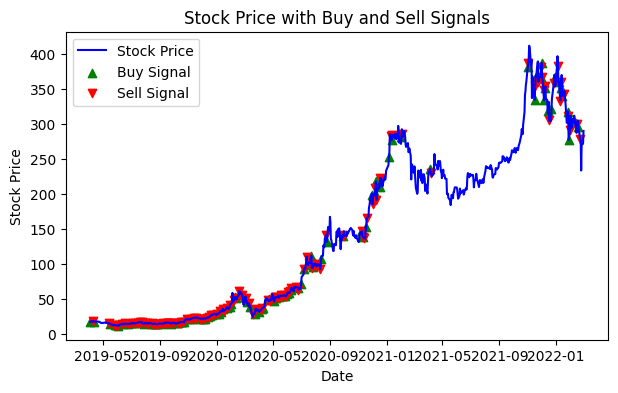

Total Returns: 726.46%
Final Portfolio Value: 82645.68688960832
Total Profit: 72645.68688960832
Sharpe Ratio: 2.0079570195156538
Maximum Drawdown: -0.45877361211759926
Number of Trades Executed: 114
Win Ratio: 63.16%


In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

signal = y_pred_best

# Implementing the trading strategy
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
position_open = False
position_price = 0
total_profit = 0
shares_held = 0
buy = []
sell = []
profits = []
trade_outcomes = []

# For plotting the results
buy_signals = []
sell_signals = []

for i in range(len(signal)):
    # Check if we have a predicted increase and no open position
    if signal[i] == 1 and not position_open:
        shares_held = balance / merged_df2['Open'][i]
        position_open = True
        position_price = merged_df2['Open'][i]
        buy_signals.append((merged_df2['Date'][i], position_price))
        buy.append(position_price)
        sell.append(np.nan)
        print(f"Buy at {position_price}")

    # Check if we have a predicted decrease and an open position
    elif signal[i] == 0 and position_open:
        position_open = False
        sell_price = merged_df2['Open'][i]
        profit = shares_held * (sell_price - position_price)
        total_profit += profit
        balance += profit
        shares_held = 0
        sell_signals.append((merged_df2['Date'][i], sell_price))
        sell.append(sell_price)
        buy.append(np.nan)
        profits.append(profit)
        trade_outcomes.append(1 if profit > 0 else 0)
        print(f"Sell at {sell_price}, Profit: {profit}")
    else:
        buy.append(np.nan)
        sell.append(np.nan)

# Print the final balance and total profit
print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {balance}")
print(f"Total Profit: {total_profit}")



# Plot the stock price along with buy and sell signals
plt.figure(figsize=(7, 4))
plt.plot(merged_df2['Date'], merged_df2['Open'], label='Stock Price', color='blue')
plt.scatter(*zip(*buy_signals), label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(*zip(*sell_signals), label='Sell Signal', marker='v', color='red', alpha=1)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price with Buy and Sell Signals')
plt.legend()
plt.show()

# Calculate returns
returns = (balance - initial_balance) / initial_balance
print(f"Total Returns: {returns * 100:.2f}%")

# Final Portfolio Value
if position_open:
    final_portfolio_value = balance + (shares_held * merged_df2['Open'].iloc[-1])
else:
    final_portfolio_value = balance

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Total Profit: {final_portfolio_value - initial_balance}")

# Calculate the Sharpe Ratio
returns_series = pd.Series(profits)
sharpe_ratio = returns_series.mean() / returns_series.std() * np.sqrt(len(profits))
print(f"Sharpe Ratio: {sharpe_ratio}")

# Calculate Maximum Drawdown
portfolio_values = [initial_balance] + [initial_balance + sum(profits[:i+1]) for i in range(len(profits))]
portfolio_values = pd.Series(portfolio_values)
rolling_max = portfolio_values.cummax()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
print(f"Maximum Drawdown: {max_drawdown}")

# Number of trades executed
num_trades = len(profits)
print(f"Number of Trades Executed: {num_trades}")

# Win Ratio
win_ratio = np.mean(trade_outcomes)
print(f"Win Ratio: {win_ratio * 100:.2f}%")
